In [1]:
import torch
import numpy as np
import nvidia.nvcomp as nvcomp
import PIL.Image
import matplotlib.pyplot as plt
from torchvision.transforms.v2.functional import pil_to_tensor
from torch.distributions import Categorical

tensor(2.0340, dtype=torch.float64)


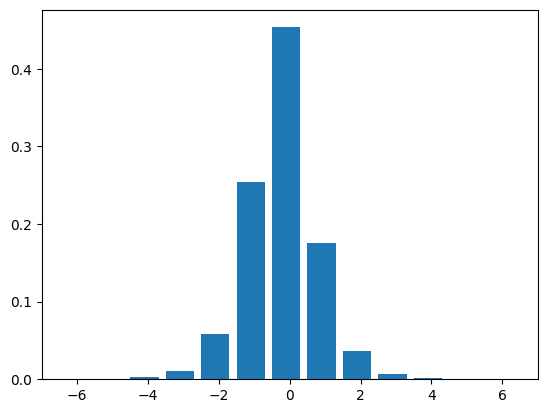

In [2]:
device = "cuda"
x = pil_to_tensor(PIL.Image.open("compressed.png")).to(device)
x = (x.to(torch.int16) - 128).to(torch.int8)

h = plt.hist(x.cpu().flatten(),range=(-127.5,127.5),bins=255,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([-7,7])
print(bpc)

In [3]:
def encode(codec, x):
    shape = x.shape
    x_flat = x.contiguous().view(-1)
    nvcomp_array = nvcomp.as_array(x_flat)
    c = codec.encode(nvcomp_array)
    return c, shape

def decode(codec, c, shape):
    decompressed_array = codec.decode(c)
    xhat_flat = torch.utils.dlpack.from_dlpack(decompressed_array.to_dlpack())
    xhat = xhat_flat.view(shape)
    return xhat

In [4]:
codec = nvcomp.Codec(algorithm="bitcomp", data_type='|i1', algorithm_type=0)

In [5]:
c, shape = encode(codec, x)
print(f"Ratio: {x.numel()/c.buffer_size}")
xhat = decode(codec, c, shape)
assert torch.equal(x, xhat)

Ratio: 2.909090909090909
